# 0. Importing Libaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import datetime

### Setting up GPU

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.1.0+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Sep__8_19:56:38_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.52
Build cuda_12.3.r12.3/compiler.33281558_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
device = torch.device('cuda:0')
device 

device(type='cuda', index=0)

In [4]:
# device = torch.device('cpu')
# device

# 1. Importing and Preparing Dataset

### Downloading nltk dataset

In [5]:
import nltk
nltk.download('reuters')
nltk.download('punkt')
nltk.download('abc')

[nltk_data] Downloading package reuters to C:\Users\minnb\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\minnb\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package abc to C:\Users\minnb\nltk_data...
[nltk_data]   Package abc is already up-to-date!


True

### Import Australian Broadcasting Corporation (ABC) news for training

In [6]:
from nltk.corpus import abc
abc.words()

['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', ...]

In [7]:
# .sents() returns sentences already tokenized
corpus = abc.sents()
len(corpus)

29059

In [8]:
# Limiting the corpus to only 5000 documents since using the entire corpus
# is not feasible with available computational resources
corpus = corpus[0:5000]

In [9]:
len(corpus)

5000

In [10]:
# Convert all characters to lowercase to handle case sensitivity
corpus = [[word.lower() for word in sent] for sent in corpus]

In [11]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [12]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [13]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9774


In [14]:
#append UNK
vocab.append('<UNK>')

In [15]:
word2index['<UNK>'] = voc_size # since current word2index[0:voc_size-1]

In [16]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [17]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9775


# 2. Co occurance matrix

In [18]:
from collections import Counter

X_i = Counter(flatten(corpus))

In [19]:
skip_grams = []

for doc in corpus:
    for i in range(2, len(doc)-2):
        center = doc[i]
        outside = [doc[i-2], doc[i-1],
                   doc[i+1], doc[i-2]]
        for each_out in outside:
            skip_grams.append((center, each_out))

In [20]:
X_ik_skipgrams = Counter(skip_grams)

In [21]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [22]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function
pairs = list(combinations_with_replacement(vocab, 2))

In [23]:
len_of_pairs = len(pairs)

In [24]:
batch_size = 2  # adjust the batch size based on your memory constraints

for i in range(0, len_of_pairs, batch_size):
    batch = pairs[i:i + batch_size]

    for bigram in batch:
        if X_ik_skipgrams.get(bigram):
            co = X_ik_skipgrams[bigram]
            X_ik[bigram] = co + 1  # for stability
            X_ik[(bigram[1], bigram[0])] = co + 1  # basically apple, banana = banana, apple
        else:
            pass

        weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
        weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)


# 3. Preparing training data

### Check corpus (sentences)

In [25]:
2
for c in corpus:
    print(c)
    # Stop after 3
    i+=1
    if i > 2:
        break

['pm', 'denies', 'knowledge', 'of', 'awb', 'kickbacks', 'the', 'prime', 'minister', 'has', 'denied', 'he', 'knew', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'iraq', 'wheat', 'sales', '.']


In [26]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

# 4. Model

In [27]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)
    
    def get_vector(self, word):
        id_tensor = torch.LongTensor([word2index[word]])
        id_tensor = id_tensor
        v_embed = self.center_embedding(id_tensor)  # Corrected
        u_embed = self.outside_embedding(id_tensor)  # Corrected
        word_embed = (v_embed + u_embed) / 2 

        return word_embed

# 5. Training

In [28]:
batch_size     = 2 # mini-batch size
embedding_size = 50 #  according to word2vec paper 50-300
model          = Glove(voc_size, embedding_size)
model = model.to(device) # send model to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

In [30]:
import time

# Training
# Since our training data is small, 1000 epochs instead of between 3 and 50 as per the paper
num_epochs = 1000
total_time = 0 # Store total training time
losses = [] # Store losses over training
k = 5 # Negative sample size
start = time.time()

for epoch in range(num_epochs):
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    cooc_batch = cooc_batch.to(device)
    weighting_batch = weighting_batch.to(device)
    
    optimizer.zero_grad()
    
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        end = time.time()
        total, epoch_mins, epoch_secs = epoch_time(start, end)
        total_time += total
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()


Epoch: 100 | cost: 5.390658 | time: 0m 9s
Epoch: 200 | cost: 95.154984 | time: 0m 8s
Epoch: 300 | cost: 2.261558 | time: 0m 8s
Epoch: 400 | cost: 141.754868 | time: 0m 8s
Epoch: 500 | cost: 6.137132 | time: 0m 8s
Epoch: 600 | cost: 7.362274 | time: 0m 8s
Epoch: 700 | cost: 9.469492 | time: 0m 8s
Epoch: 800 | cost: 437.958832 | time: 0m 8s
Epoch: 900 | cost: 7.038476 | time: 0m 8s
Epoch: 1000 | cost: 0.435225 | time: 0m 8s


In [31]:
print(f'Training Loss: {loss}, Training Time: {str(datetime.timedelta(seconds=total_time))}')

Training Loss: 0.43522515892982483, Training Time: 0:01:27.563908


In [32]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/GloVe-v1.pt')

In [33]:
Data = {
    'corpus': corpus,
    'vocab': vocab,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': embedding_size
}

In [34]:
pickle.dump(Data,open('./app/models/Data.pkl', 'wb'))

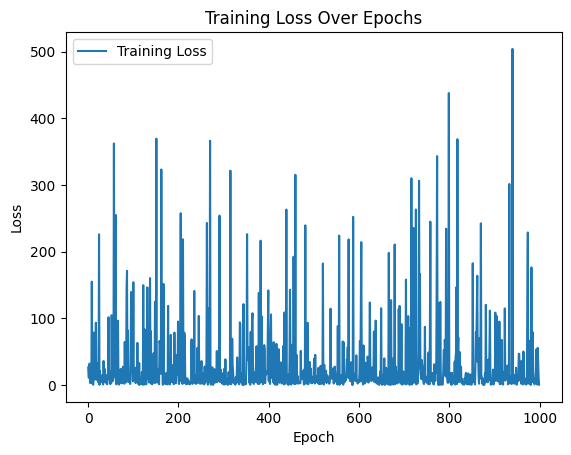

In [35]:
# Extract the numerical values from the tensors
loss_values = [loss.item() for loss in losses]

# Plot the losses
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()